# Fake News Exploratory Data Analysis

Get subset of FakeNewCorpus data set.

In [222]:
import pandas as pd
import regex as re
from cleantext import clean
raw_data = pd.read_csv('https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv',index_col=0)
raw_data.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN


Perform basic cleaning: remove urls, dates, numbers, emails.

In [223]:
data = raw_data.copy(deep = True)

In [224]:
pattern = re.compile(r"([\d]{1,2}[\/|\-][\d]{1,2}(?:[\/|\-][\d]{2,4})?|[\d]{2,4}[\/|\-][\d]{1,2}[\/|\-][\d]{1,2}|(?:january|february|march|april|may|june|july|august|september|october|november|december)[\s][\d]{1,2}[a-z][a-z](?:\s[\d]{2,4})|[\d][\d]\w?\w?\sof\s(?:january|february|march|april|may|june|july|august|september|october|november|december)(?:\s[\d]{2,4})?|(?:january|february|march|april|may|june|july|august|september|october|november|december)\s\d\d?\w?\w?,?(?:\s\d{2,4})?)")
def clean_string(s):
    s1 = pattern.sub("date", s.lower())
    s2 = clean(s1, lower=True,
                no_line_breaks=True,
                no_emails=True,
                no_urls=True,
                no_numbers=True,
                lang="en",
                replace_with_number="num",
                replace_with_email="email",
                replace_with_url="url")
    return s2
def clean_dataframe(dataframe):
    data['content'] = data['content'].apply(clean_string)

In [225]:
clean_dataframe(data)
data['content'].head()

0    sometimes the power of christmas will make you...
1    awakening of num strands of dna - "reconnectin...
2    never hike alone: a friday the 13th fan film u...
3    when a rare shark was caught, scientists were ...
4    donald trump has the unnerving ability to abil...
Name: content, dtype: object

Tokenize the text
Remove stopwords and compute reduction of vocabulary rate after having removed them
Stem words and compute reduction rate of vocabulary

In [226]:
import nltk
import itertools
from nltk.corpus import stopwords
from nltk.stem.porter import *
def preprocess(dataframe):
    # tokenize content column
    dataframe['content'] = dataframe['content'].apply(nltk.word_tokenize)
    print("Tokenizing...")
    tokens = list(itertools.chain.from_iterable(dataframe['content']))
    vocabulary = set(tokens)
    # remove stopwords
    d = stopwords.words('english')
    print("Removing stopwords...")
    dataframe['content'] = [[token for token in token_list if token not in d] for token_list in dataframe['content']]
    tokens_no_stopwords = list(itertools.chain.from_iterable(dataframe['content']))
    vocabulary_no_stopwords = set(tokens)
    print("Reduction rate of removing stopwords: " + str(1 - len(vocabulary_no_stopwords) / len(vocabulary)))
    # stem tokens
    stemmer = PorterStemmer()
    print("Stemming...")
    dataframe['content'] = [[stemmer.stem(token) for token in token_list if token not in d] for token_list in dataframe['content']]
    tokens_stem = list(itertools.chain.from_iterable(dataframe['content']))
    vocabulary_stem = set(tokens_stem)
    print("Reduction rate of stemming: " + str(1 - len(vocabulary_stem)/len(vocabulary_no_stopwords)))

In [227]:
preprocess(data)
data['content']

Tokenizing...
Removing stopwords...
Reduction rate of removing stopwords: 0.0
Stemming...
Reduction rate of stemming: 0.3214631782945736


0      [sometim, power, christma, make, wild, wonder,...
1      [awaken, num, strand, dna, -, ``, reconnect, '...
2      [never, hike, alon, :, friday, 13th, fan, film...
3      [rare, shark, caught, ,, scientist, left, blun...
4      [donald, trump, unnerv, abil, abil, creat, rea...
                             ...                        
245    [prison, rahm, ,, god, 's, work, mani, other, ...
246    [num, use, item, tini, home, headlin, :, bitco...
247    [former, cia, director, michael, hayden, said,...
248    [antonio, sabato, jr., say, hollywood, 's, lib...
249    [former, u.s., presid, bill, clinton, monday, ...
Name: content, Length: 250, dtype: object

Next, we define functions that can visualize our dataset

In [228]:
import numpy as np
import matplotlib.pyplot as plt

In [229]:
def pair_keyword_type(keyword): 
    dataarray = []
    for i in range(0,data.__len__()): 
        instances = data.content[i].count(str(keyword))
        dataarray.append((instances,data.type[i]))
    return dataarray

In [230]:
def scatterplot_keyword_type(keyword):
    pair_keyword_list = pair_keyword_type(keyword)
    tuple_array = pair_keyword_type(keyword)
    typearray = []
    countarray = []
    for i in range(0,pair_keyword_list.__len__()): 
        typearray.append(str(tuple_array[i][1]))
        countarray.append(tuple_array[i][0])
    fig = plt.figure()
    ax =fig.add_axes([0,0,2,1])
    ax.scatter(typearray,countarray)
    plt.xticks(rotation = 'vertical')
    plt.show()

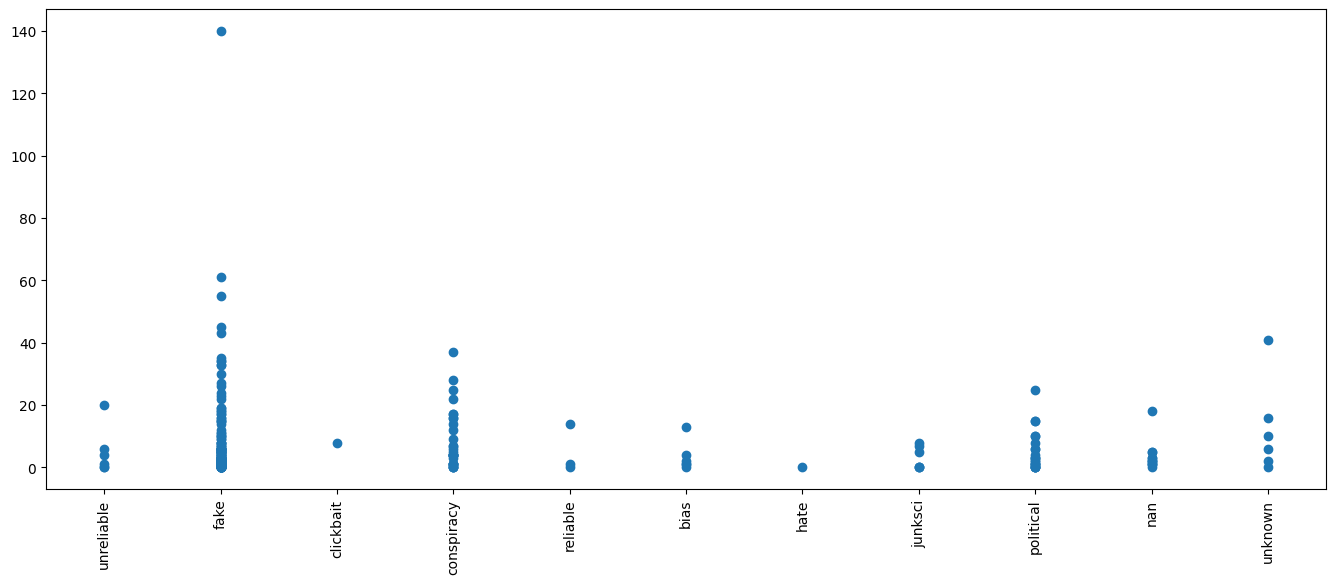

In [231]:
scatterplot_keyword_type('num')

In [232]:
def boxplot_keyword_type(keyword):
    tuple_array=pair_keyword_type(keyword) 
    boxdata=[]
    dict = {}
    for i in range(0,len(tuple_array)):
        if tuple_array[i][1] not in dict:
            dict[tuple_array[i][1]] = [tuple_array[i][0]]
        else:
            dict[tuple_array[i][1]].append(tuple_array[i][0])
    for i in dict:
        boxdata.append(dict[i])
    fig = plt.figure()
    ax =fig.add_axes([0,0,2,1])
    ax.boxplot(boxdata, labels = list(dict.keys()))
    plt.xticks(rotation = 'vertical')
    plt.show()

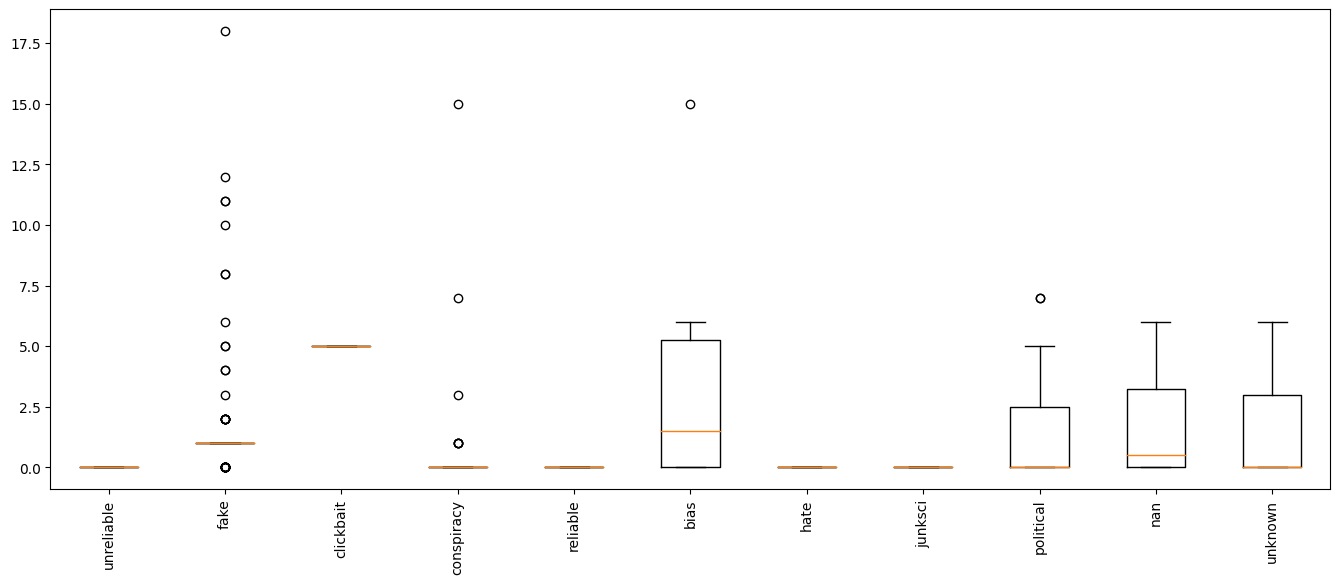

In [233]:
boxplot_keyword_type('trump')

In [234]:
def barplot_keyword_type(keyword): 
    tuple_array = pair_keyword_type(keyword)
    rawdict = {}
    for i in range(0,len(tuple_array)):
        if tuple_array[i][1] not in rawdict:
            rawdict[tuple_array[i][1]] = [tuple_array[i][0]]
        else:
            rawdict[tuple_array[i][1]].append(tuple_array[i][0])

    meandict={}
    for i in rawdict: 
        meandict[i] = np.mean(rawdict[i])
    mediandict={}
    for i in rawdict: 
        mediandict[i] = np.median(rawdict[i])
    meanvals =[]
    medianvals=[]
    for i in mediandict:
        medianvals.append(mediandict[i])
    for i in meandict:
        meanvals.append(meandict[i])
    types = list(mediandict.keys())
    types = [str(i) for i in types]
    print(medianvals)
    print(meanvals)
    print(types)
    df = pd.DataFrame({
    'types': types,
    'meanvals': meanvals,
    'medianvals': medianvals
    })
    df.plot(x="types", y=["meanvals", "medianvals"], kind="bar", figsize=(10,5))
    

[2.5, 3.0, 8.0, 4.0, 1.0, 1.5, 0.0, 2.5, 3.0, 2.0, 8.0]
[5.166666666666667, 7.7935483870967746, 8.0, 8.709677419354838, 5.0, 3.5, 0.0, 3.3333333333333335, 5.043478260869565, 3.5833333333333335, 12.5]
['unreliable', 'fake', 'clickbait', 'conspiracy', 'reliable', 'bias', 'hate', 'junksci', 'political', 'nan', 'unknown']


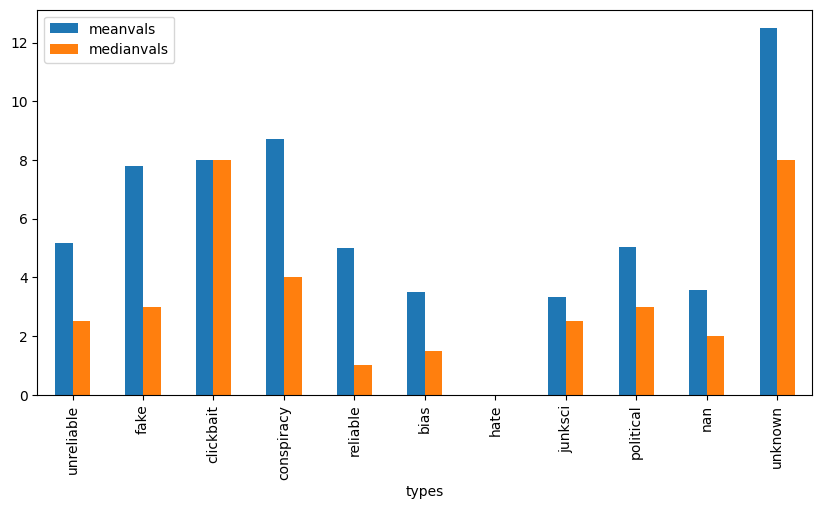

In [235]:
barplot_keyword_type('num') 